# TorchVision for Pre-Processing

Welcome to the first lab of this module! Before a deep learning model can learn to "see", the visual data you feed it must be carefully prepared. Raw images come in various sizes and formats, but neural networks require a standardized input, specifically, a **tensor**.

This is where **TorchVision** comes in. As PyTorch’s standard toolkit for computer vision, it provides powerful and efficient tools designed to handle the common, often tedious, components of a vision workload. Instead of reinventing the wheel, you can use TorchVision’s battle tested data pipelines and functions to focus on building innovative models.

In this lab, you will:

* Practice converting images between the common **Pillow (PIL)** image format and **PyTorch Tensors**.
* Explore handy **TorchVision utilities** like `make_grid` and `save_image` to simplify debugging and visualize batches of images.
* Apply individual transformations to resize, crop, and augment images, and see their effects.
* Define and implement a **custom transformation** from scratch to add a unique effect on the dataset.
* Chain transforms together using `transforms.Compose` to build powerful and reusable **preprocessing and data augmentation pipelines**.

By the end of this lab, you'll have a solid understanding of how to build a complete image preparation workflow from the ground up.

## Imports

In [1]:
import os

from IPython.display import Image as DisplayImage
import numpy as np
from PIL import Image
import torch
import torch.utils.data as data
from torchvision import datasets
from torchvision.io import decode_image
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tqdm.auto import tqdm

import helper_utils

In [2]:
# Check if the OxfordIIITPet data folder exists
ox3_pet_data_path = './oxford3pet_data'
if os.path.exists(ox3_pet_data_path) and os.path.isdir(ox3_pet_data_path):
    ox3_pet_download = False  # Data folder exists, will be loaded from
else:
    ox3_pet_download = True  # Data folder doesn't exist, will be downloaded

## Image Conversion (PIL and Tensor)

Your first practical step in any computer vision workflow is to bridge the gap between how humans see images and how machines process them. An image file is a grid of pixels, often handled by a library like Pillow (PIL). A neural network, however, requires a numerical format it can perform calculations on: a **Tensor**.

Gaining fluency in converting between these two formats is a foundational skill. It's the mechanism that lets you load, process, and inspect your data at every stage of a project.

To begin, you will perform a "roundtrip" conversion. By taking a PIL image, changing it to a PyTorch Tensor, and then converting it back, you'll confirm that this core operation is seamless and preserves your data perfectly. This is a vital sanity check before building more complex pipelines.

* Load an image with Pillow from a file using the Pillow (PIL) library.
    * Note that Pillow reports dimensions in `(Width, Height)` format.

In [3]:
# Load an image
image = Image.open('./images/mangoes.jpg')

# Dimensions of the original PIL image
print("Original PIL Image Dimensions:", image.size)
print(f"The maximum pixel value is: {image.getextrema()[0][1]}, and the minimum is: {image.getextrema()[0][0]}")

Original PIL Image Dimensions: (2048, 2048)
The maximum pixel value is: 255, and the minimum is: 0


<br>

* `transforms.ToTensor()`: Converts a PIL image object into a PyTorch Tensor.
    * **Dimension Change**: This transform rearranges the image data from Pillow's `(Width, Height)` format to PyTorch's `(Channels, Height, Width)` format.  It also scales the image's pixel values from the `[0, 255]` range to a floating point `[0.0, 1.0]` range.

In [4]:
# Convert the PIL image to a PyTorch Tensor
img_tensor = transforms.ToTensor()(image)

# Dimensions (shape) of the tensor
# [C, H, W] format
print(f"Dimensions After Converting to a Tensor: {img_tensor.shape}")
print(f"The maximum pixel value is: {img_tensor.max()}, and the minimum is: {img_tensor.min()}")

Dimensions After Converting to a Tensor: torch.Size([3, 2048, 2048])
The maximum pixel value is: 1.0, and the minimum is: 0.0


<br>

* `transforms.ToPILImage()`: Converts a PyTorch Tensor back into a PIL image object.
    * **Dimension Change**: It performs the reverse, converting a `(Channels, Height, Width)` tensor back into a PIL image that reports its size as `(Width, Height)`.

In [5]:
# Convert the tensor back to a PIL image
img_pil = transforms.ToPILImage()(img_tensor)

# Dimensions of the converted back PIL image
print("Dimensions After Converting Back to PIL:", img_pil.size)

Dimensions After Converting Back to PIL: (2048, 2048)


<br>

* Display the original and the converted images side-by-side to visually confirm that the "roundtrip" process preserved the image content perfectly.

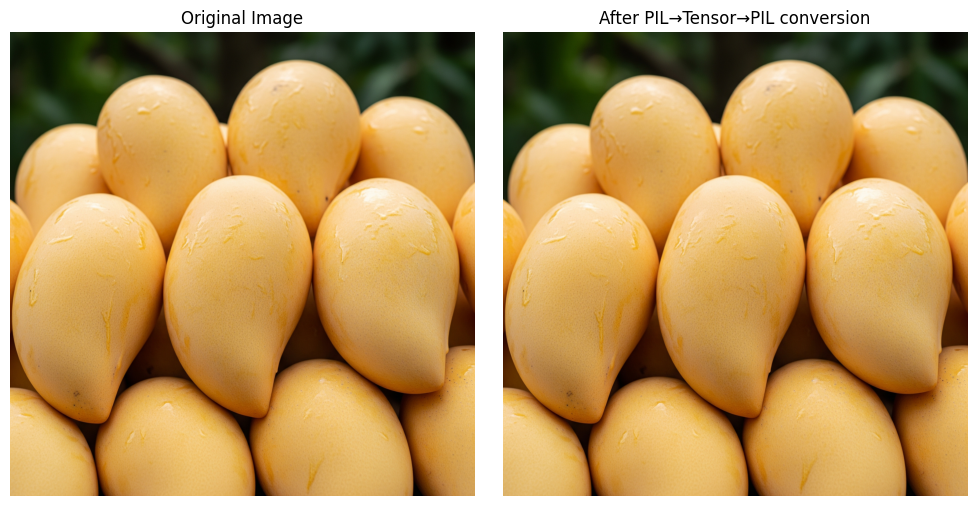

In [6]:
# Visualize the original and converted images
helper_utils.show_images([image, img_pil], titles=("Original Image", "After PIL→Tensor→PIL conversion"))

## TorchVision Utilities for Image Handling

TorchVision equips you with a powerful toolkit for the practical logistics of a computer vision project. These utilities are designed to manage the entire lifecycle of your image data, from initial loading to final output. Mastering them allows you to efficiently load data, debug your pipeline by visualizing what your model is seeing, and save your results professionally.

You will now explore three indispensable functions that address these core needs:

* `decode_image`: Instantly converts compressed image files like JPEGs or PNGs directly into tensors.

* `make_grid`: Arranges a batch of images into a clean, single grid, which is perfect for at-a-glance inspection and analysis.

* `save_image`: Saves your tensor-based images back to a standard file format, making it easy to share results for reports or presentations.

### Decoding Images into Tensors with `decode_image`

The `decode_image` function is designed for one primary purpose: to efficiently convert an image file directly into a **numerical PyTorch tensor** for computation. It reads an image and immediately returns a tensor in the `[Channels, Height, Width]` format, ready for subsequent processing. Unlike `Image.open`, which returns a visual PIL object for immediate display or editing, the tensor from `decode_image` is a purely numerical object. This makes it the ideal choice when your workflow begins with computation, not visualization.

* <code>[decode_image()](https://docs.pytorch.org/vision/stable/generated/torchvision.io.decode_image.html)</code>: Loads an image (e.g., JPEG, PNG) and converts it into a `torch.uint8` PyTorch Tensor.
    * **Dimension Ordering**: The output tensor follows the standard PyTorch **channel-first convention** (`[C, H, W]`), which important for model compatibility. 'C' is the number of channels (e.g., 3 for an RGB image), 'H' is height, and 'W' is width.

In [7]:
# Define the path to the image file.
image_path = './images/apples.jpg'

# Load the image
image = decode_image(image_path)

print(f"Image tensor dimensions: {image.shape}")
print(f"Image tensor dtype: {image.dtype}")
print(f"The maximum pixel value is: {image.max()}, and the minimum is: {image.min()}\n")

Image tensor dimensions: torch.Size([3, 2048, 2048])
Image tensor dtype: torch.uint8
The maximum pixel value is: 255, and the minimum is: 0



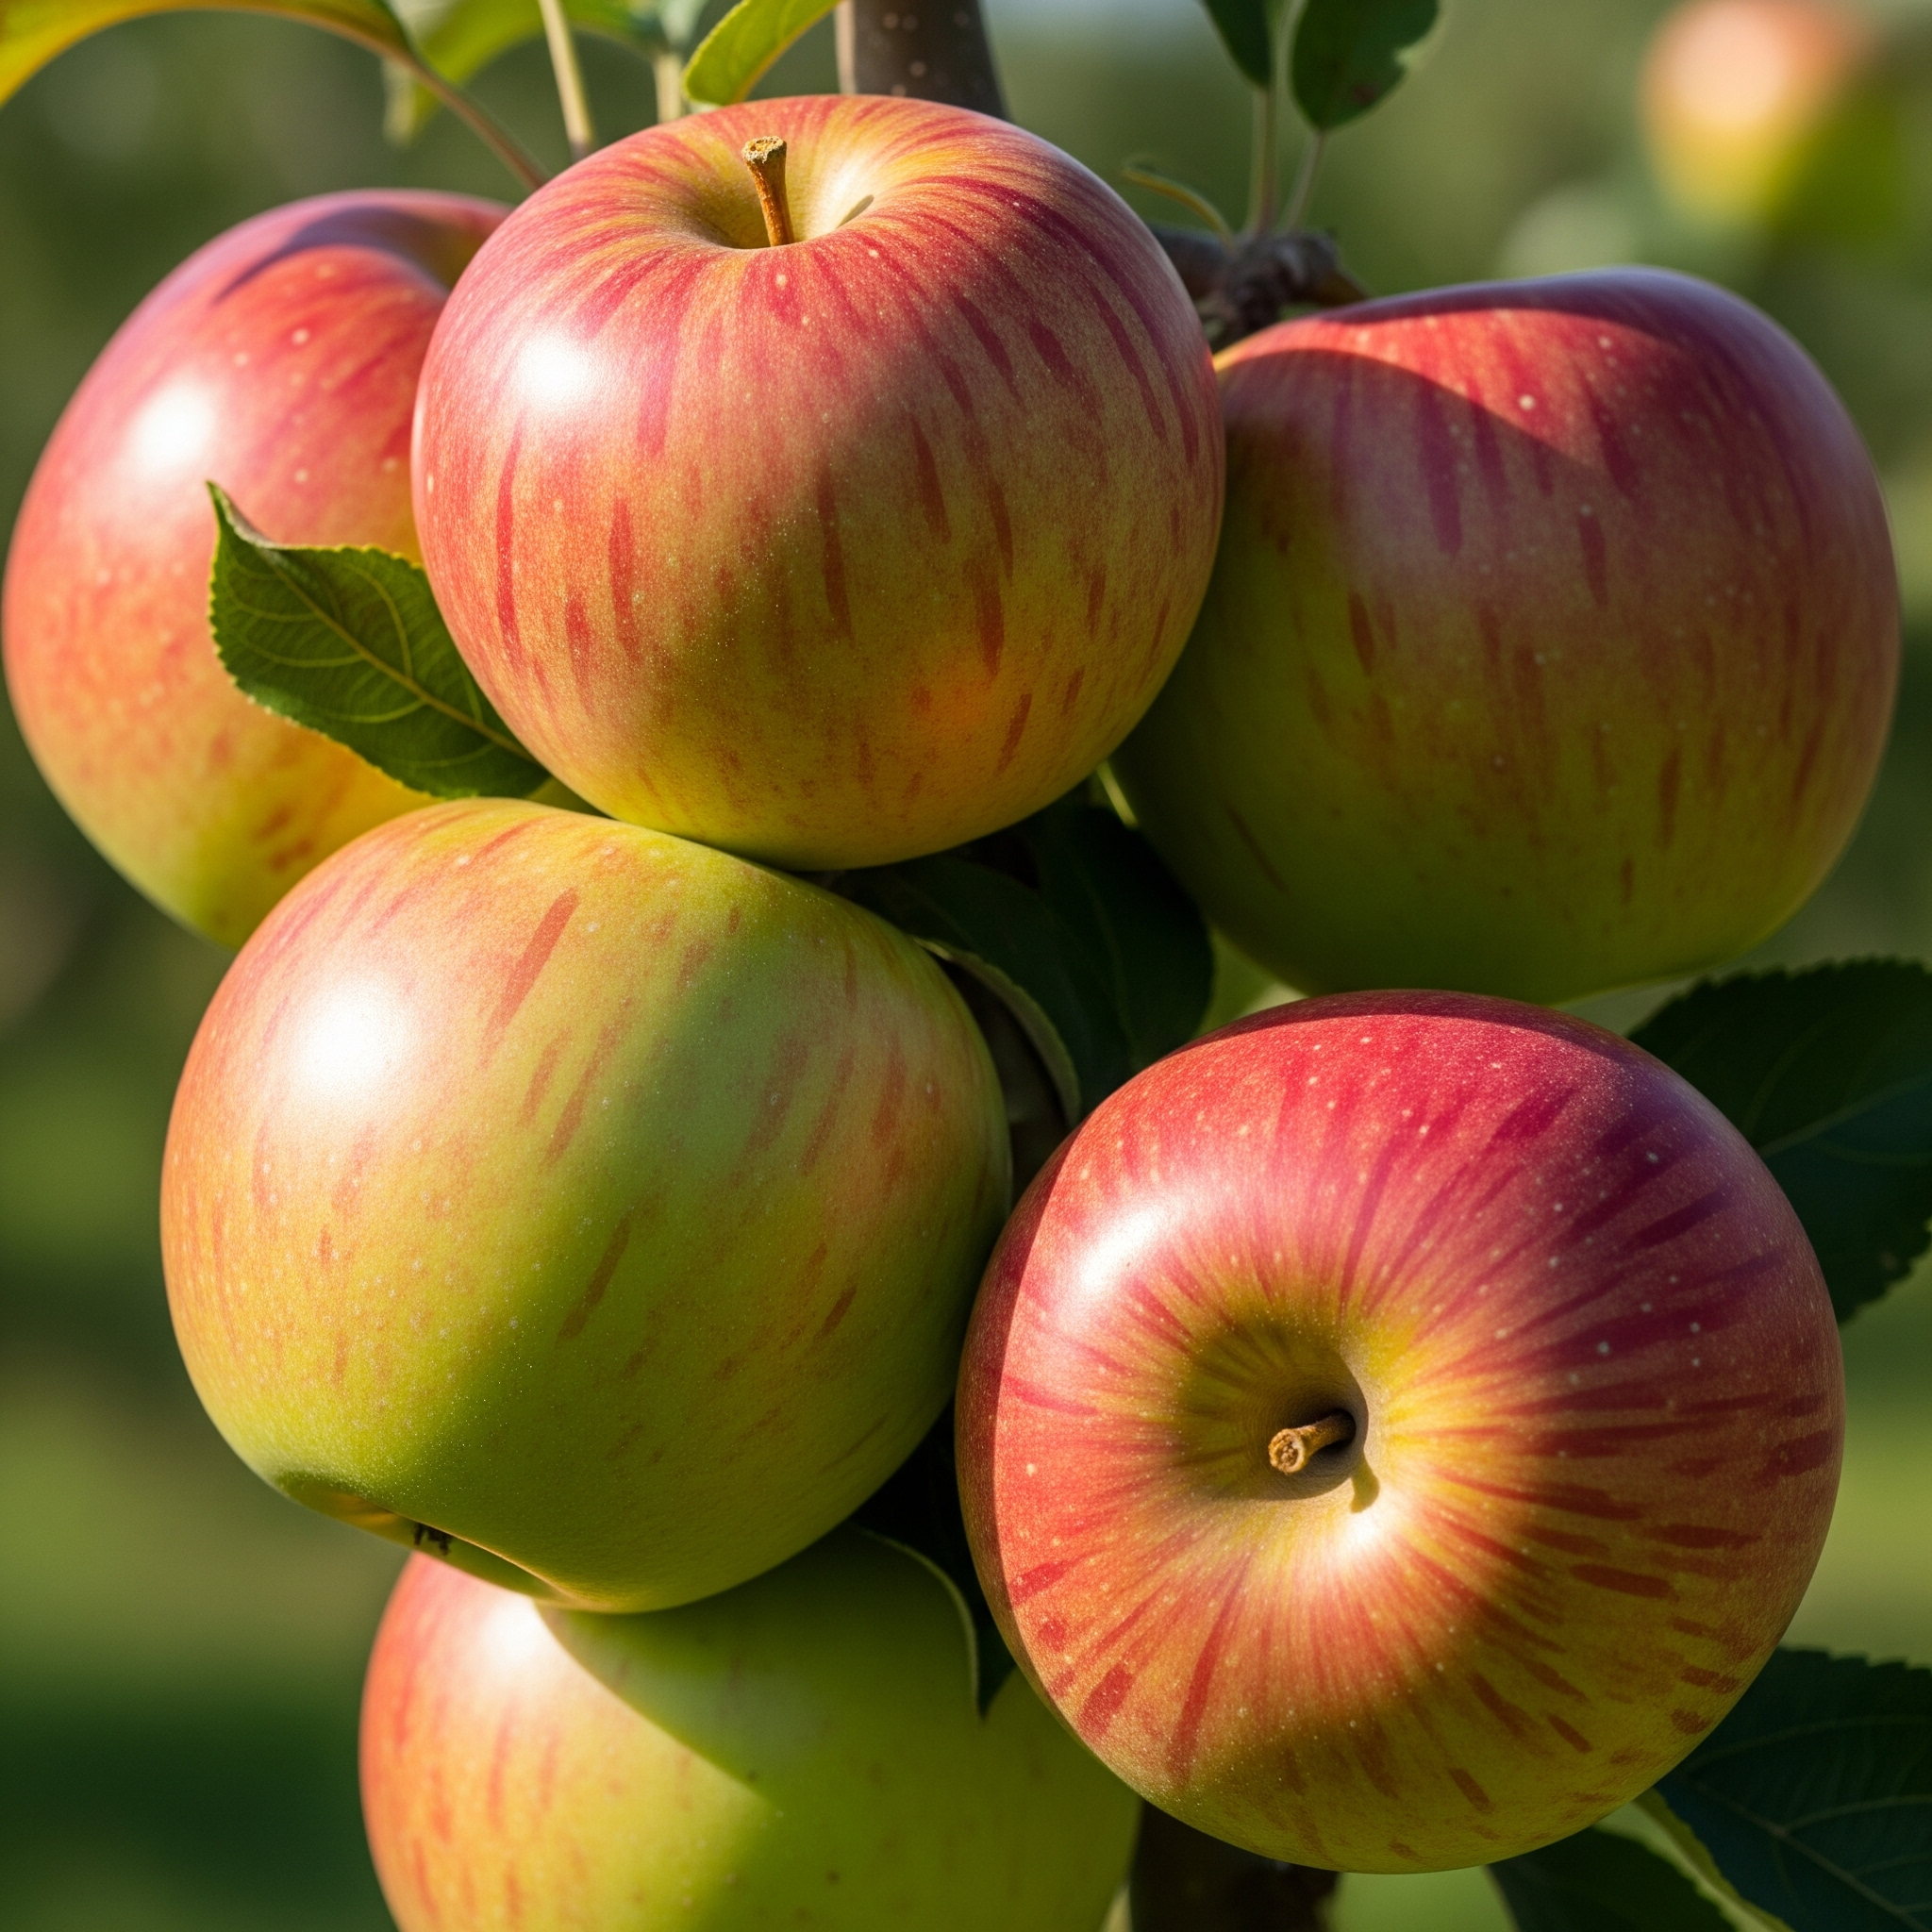

In [8]:
# Use the DisplayImage to render the image
DisplayImage(image_path, width=500, height=500)

### Creating Image Grids with `make_grid`

In deep learning, you almost always process data in **batches**, not single images. But how do you get a quick, holistic view of an entire batch at once? Displaying them individually is inefficient.

The `make_grid` function is the professional solution to this common challenge. It’s an essential utility that takes a batch of image tensors and arranges them into a single, clean grid for easy inspection. This is a vital step for visual debugging, allowing you to instantly check the results of your data augmentation or see exactly what a `DataLoader` is feeding to your model.

* Load a batch of images from a local folder (`"./images/"`).
    * The images are loaded as a single tensor containing all the image data, which is what the `make_grid` function expects.

In [9]:
# Create a batch of images (./images/ contains only 6 images). The images are loaded as 300x300 pixels
images_tensor = helper_utils.load_images("./images/")

# The size is 6 images x 3 color channels x 300 pixels height x 300 pixels width
print(f"Image tensor dimensions: {images_tensor.shape}")

Image tensor dimensions: torch.Size([6, 3, 300, 300])


* Arrange the loaded images into a grid using the <code>[make_grid()](https://docs.pytorch.org/vision/main/generated/torchvision.utils.make_grid.html)</code> function.
    * `tensor:` This needs to be a batch of images, as a **4D tensor** (`(B x C x H x W)`), to be placed into the grid.
    * `nrow=3`: Arranges the images with **3 images in each row**.
    * `padding=5`: Adds **5 pixels** of space between the images.
    * `normalize=True`: Shifts the image pixel values to a standard range (0 to 1) for consistent display.

Feel free to modify the parameters, and observe how it affects the image.

Image tensor dimensions: torch.Size([3, 615, 920])
The maximum pixel value is: 1.0, and the minimum is: 0.0



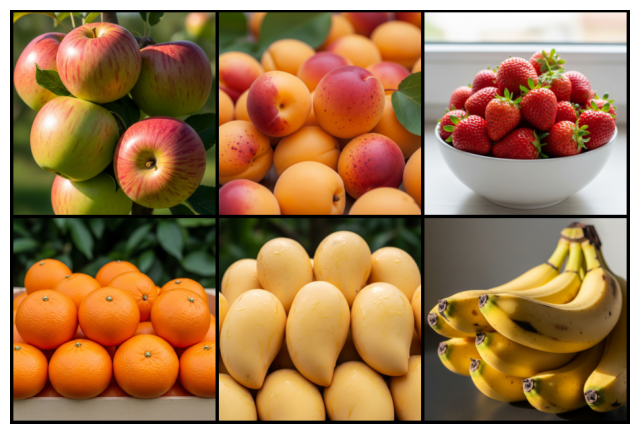

In [10]:
# Make a grid from the loaded images (2 rows of 3 for 6 images)
grid = vutils.make_grid(tensor=images_tensor, nrow=3, padding=5, normalize=True)

# the shape comes from 
# num_images/nrow*pixel_height+(num_images/nrow+1)*padding = 2*300+3*5 = 615
# nrow*pixel_width+(nrow+1)*padding = 3*300+4*5 = 920
print(f"Image tensor dimensions: {grid.shape}")
print(f"The maximum pixel value is: {grid.max()}, and the minimum is: {grid.min()}\n")

# Display the grid of images using a helper function
helper_utils.display_grid(grid)

### Saving Tensors as Images with `save_image`

Your work inside a PyTorch environment, whether it's a data grid you've created for debugging or an image generated by a model, exists as a tensor. To make this work tangible and shareable for reports, presentations, or future use, you need to export it back into a standard image file.

The `save_image` function is the straightforward solution for this final step. It takes your tensor and efficiently saves it as a high-quality image file, such as a PNG or JPG, completing the "roundtrip" from file to tensor and back again.

* <code>[save_image()](https://docs.pytorch.org/vision/main/generated/torchvision.utils.save_image.html)</code>: Saves the image tensor to a file.
    * `tensor`: The tensor of image(s) to be saved.
    * `fp`: The file path, with the name and format for the output image.
    
You can observe the image file in the left sidebar.

In [11]:
# Define the path to save the image file.
image_path = "./fruits_grid.png"

# Save the grid as a PNG image
vutils.save_image(tensor=grid, fp=image_path)

* Once the tensor has been saved to a file using `save_image`, it can be treated like any regular image and displayed.

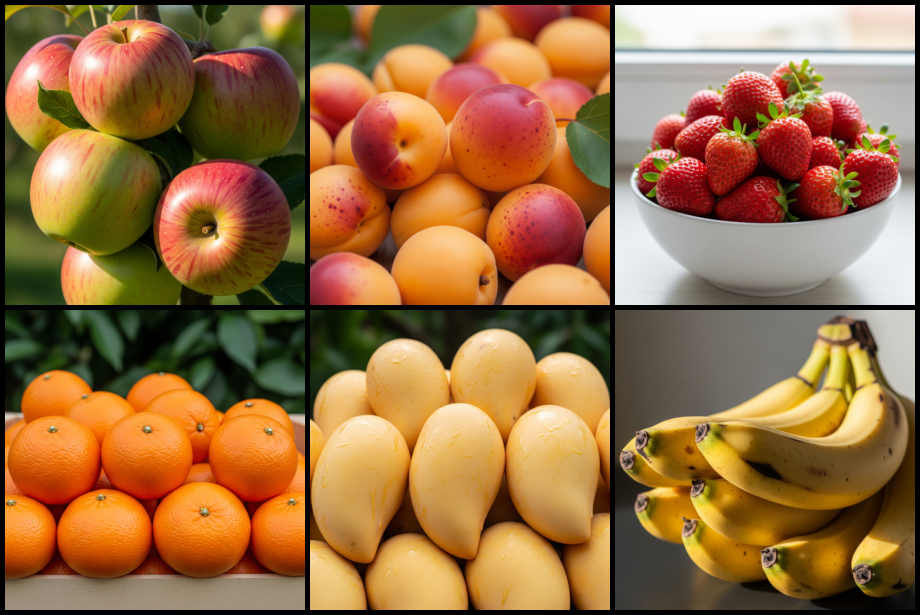

In [12]:
# Use the DisplayImage to render the image
DisplayImage(image_path)

## Image Transformations and Data Augmentation

Image transformations are a fundamental part of preparing data for a neural network. You use them not only to standardize the size and format of images but also to perform **data augmentation**. Augmentation artificially increases the diversity of your training data by creating modified versions of existing images. This helps the model become more robust and generalize better to new, unseen data.

The key thing to remember is that the **order in which you apply these transformations matters**. A common and effective practice is to first apply geometric transformations (like resizing and cropping), then color and other augmentations, and finally, convert the image to a tensor and normalize it. This ensures that augmentations are applied consistently and that the final data is in the correct format for the model.

### A Closer Look at Individual Transformations

Before you combine transformations into a powerful pipeline, examine some of the most common ones individually. Understanding the specific effect of each transform is important for building an effective data augmentation strategy.

As you explore these different transformation techniques, you're encouraged to experiment with various configurations to observe their distinct outputs and how they might impact your model's performance.

In [13]:
original_image = Image.open('./images/strawberries.jpg')

#### Resize

The [Resize](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform is a common preprocessing step to ensure all images in a batch have the same dimensions.

* It rescales an input PIL image to a desired `size`.
    * `size`: The target output size.

In [14]:
# Define the resize transformation (50x50 square)
resize_transform = transforms.Resize(size=50)

# Apply the transformation
resized_image = resize_transform(original_image)

Original Dimensions: (2048, 2048)
Resized Dimensions:  (50, 50)



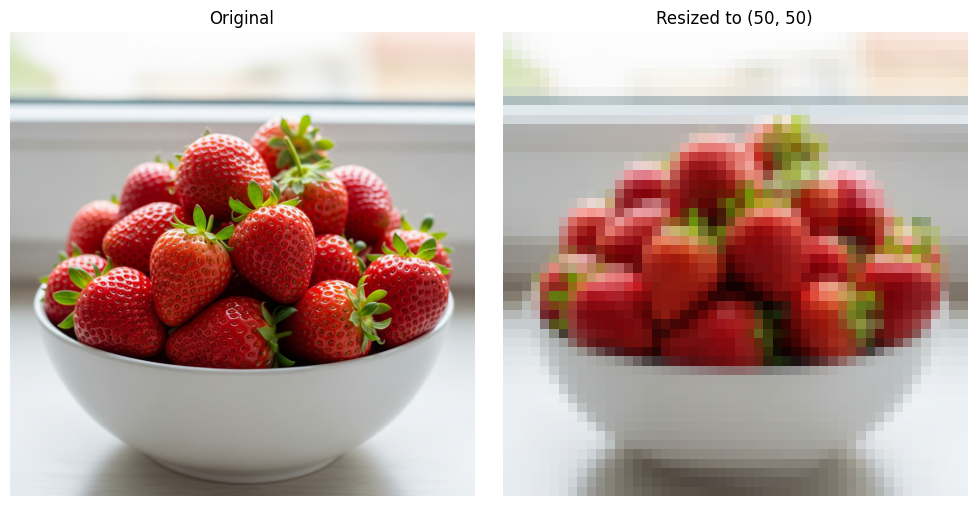

In [15]:
# (Width, Height)
print(f"Original Dimensions: {original_image.size}")
print(f"Resized Dimensions:  {resized_image.size}\n")

helper_utils.show_images(
    images=[original_image, resized_image], 
    titles=("Original", "Resized to (50, 50)")
)

#### CenterCrop

The [CenterCrop](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.CenterCrop.html) transform is used to focus on the central part of an image, removing potentially distracting background from the edges.

* It extracts a square patch from the center of the image.
    * `size`: An integer defining the height and width of the desired crop.

In [16]:
# Define the center crop transformation (256x256)
center_crop_transform = transforms.CenterCrop(size=256)

# Apply the transformation
cropped_image = center_crop_transform(original_image)

Original Dimensions: (2048, 2048)
Cropped Dimensions:  (256, 256)



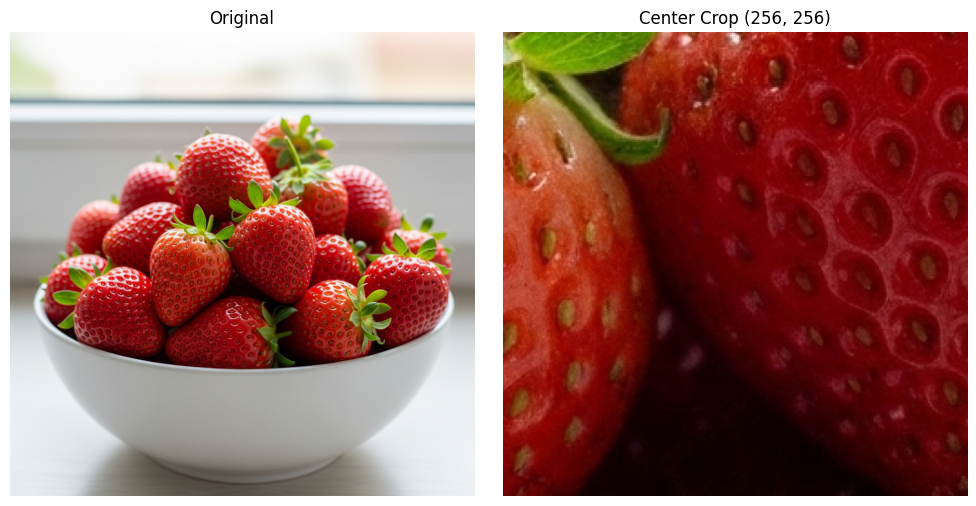

In [17]:
# (Width, Height)
print(f"Original Dimensions: {original_image.size}")
print(f"Cropped Dimensions:  {cropped_image.size}\n")

helper_utils.show_images(
    images=[original_image, cropped_image],
    titles=("Original", "Center Crop (256, 256)")
)

#### RandomResizedCrop

The [RandomResizedCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomResizedCrop.html) transform is a data augmentation technique that randomly crops a portion of the image and then resizes it to a given size. This helps the model become more robust to variations in object scale and position within the image. Because it involves random selection, each time you apply this transform, you'll likely get a slightly different cropped and resized version of the image.

* It crops a random portion of an image and resizes it to a specified size.
    * `size`: The target output size.

In [18]:
# Define the RandomResizedCrop transformation (224x224)
random_resized_crop_transform = transforms.RandomResizedCrop(size=224)

# Apply the transformation
cropped_resized_image_1 = random_resized_crop_transform(original_image)
cropped_resized_image_2 = random_resized_crop_transform(original_image)
cropped_resized_image_3 = random_resized_crop_transform(original_image)

Original Dimensions: (2048, 2048)
RandomResizedCrop 1 Dimensions:  (224, 224)
RandomResizedCrop 2 Dimensions:  (224, 224)
RandomResizedCrop 3 Dimensions:  (224, 224)



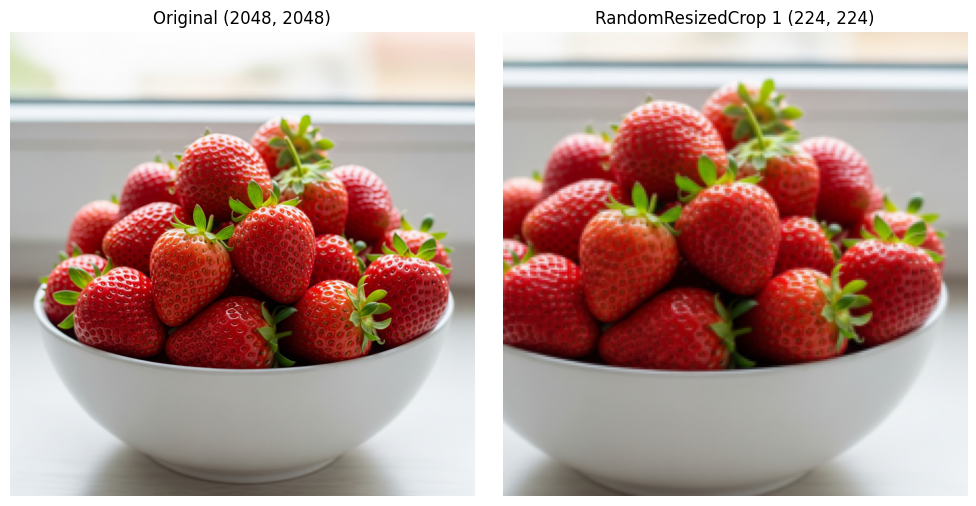

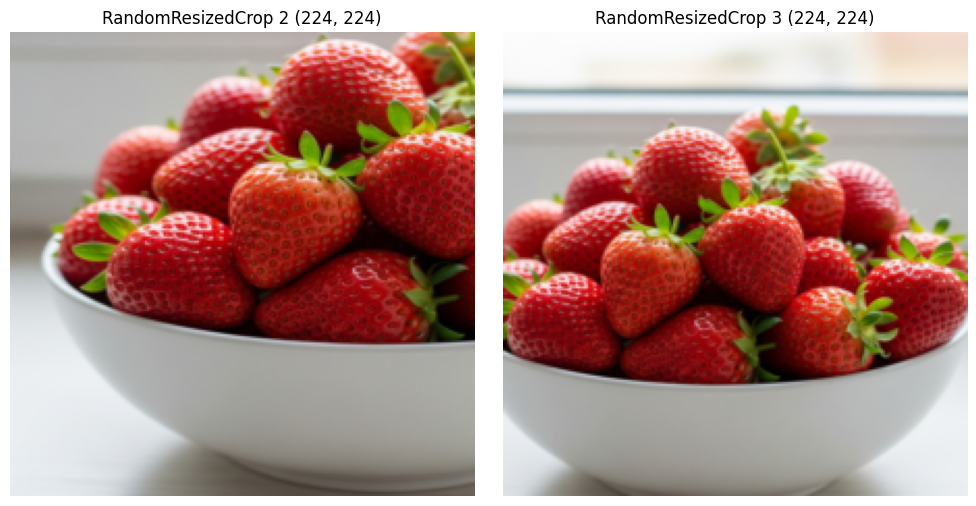

In [19]:
# (Width, Height)
print(f"Original Dimensions: {original_image.size}")
print(f"RandomResizedCrop 1 Dimensions:  {cropped_resized_image_1.size}")
print(f"RandomResizedCrop 2 Dimensions:  {cropped_resized_image_2.size}")
print(f"RandomResizedCrop 3 Dimensions:  {cropped_resized_image_3.size}\n")

helper_utils.show_images(
    images=[original_image, cropped_resized_image_1],
    titles=("Original (2048, 2048)", "RandomResizedCrop 1 (224, 224)")
)
helper_utils.show_images(
    images=[cropped_resized_image_2, cropped_resized_image_3],
    titles=("RandomResizedCrop 2 (224, 224)", "RandomResizedCrop 3 (224, 224)")
)


#### RandomHorizontalFlip

[RandomHorizontalFlip](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html) is a data augmentation technique that randomly flips the image horizontally. It teaches the model that an object's identity doesn't change if it's mirrored.

* It flips the image horizontally with a given probability.
    * `p`: The probability of the flip being applied. The default is 0.5.

In [20]:
# Define the horizontal flip transformation
# Set p=1.0 to guarantee the flip happens for this demonstration
flip_transform = transforms.RandomHorizontalFlip(p=1.0)

# Apply the transformation
flipped_image = flip_transform(original_image)

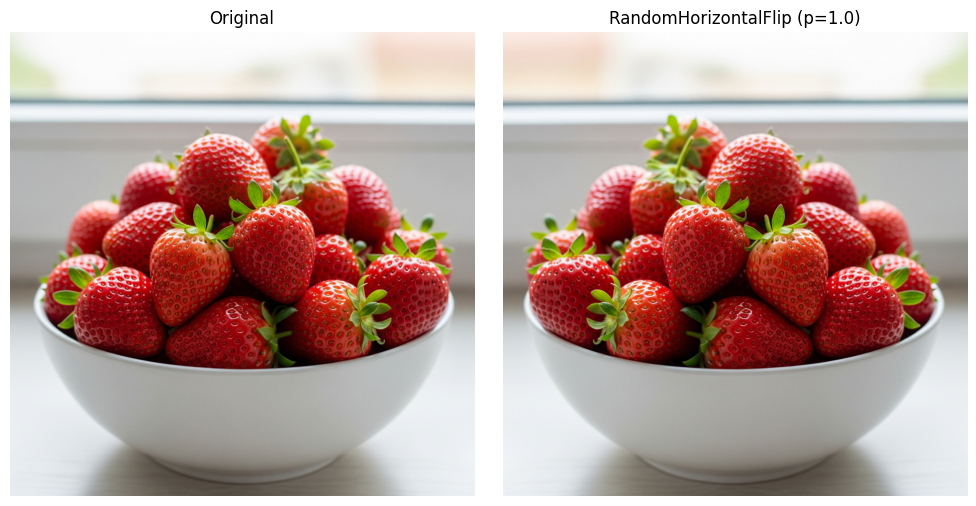

In [21]:
helper_utils.show_images(
    images=[original_image, flipped_image],
    titles=("Original", "RandomHorizontalFlip (p=1.0)")
)

#### ColorJitter

[ColorJitter](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html), a data augmentation technique, makes the model more robust to variations in lighting and color by randomly altering the image's color properties.

* It randomly changes the brightness, contrast, and saturation of an image.
    * The `brightness`, `contrast` and `saturation` parameters control the range of the random adjustments.

In [22]:
# Define the ColorJitter transformation
# The values determine the random range for each property.
jitter_transform = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)

# Apply the transformation
jittered_image = jitter_transform(original_image)

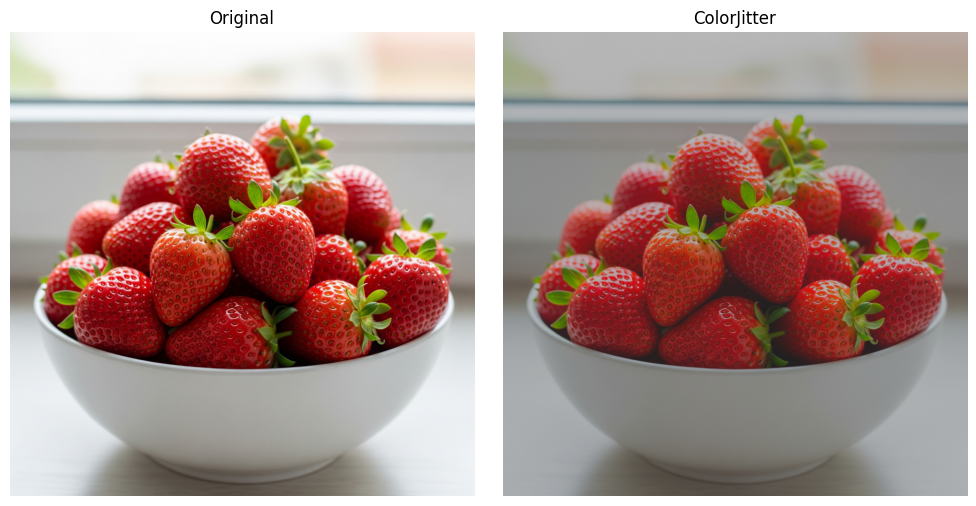

In [23]:
helper_utils.show_images(
    images=[original_image, jittered_image],
    titles=("Original", "ColorJitter")
)

#### Custom Transformations

In some cases, you may need a specific operation that isn't built-in, like simulating a particular type of camera noise. In these situations, you can create your own custom transformations.

* A custom transform is created by defining a Python class with a `__call__` method.
    * This method takes a PIL image as input and returns the modified image, allowing it to be seamlessly integrated into a `transforms.Compose` pipeline.
* Define a transform to apply salt and pepper noise, which adds random white (255) and black (0) pixels to an image. This particular transformation is considered a data augmentation technique.

In [24]:
class SaltAndPepperNoise:
    """
    A custom transform to add salt and pepper noise to a PIL image.

    Args:
        salt_vs_pepper (float): The ratio of salt to pepper noise.
                                (e.g., 0.5 is an equal amount of each).
        amount (float): The total proportion of pixels to be affected by noise.
    """
    def __init__(self, salt_vs_pepper=0.5, amount=0.04):
        self.s_vs_p = salt_vs_pepper
        self.amount = amount

    def __call__(self, image):
        # Make a copy of the image
        output = np.copy(np.array(image))

        # Add Salt Noise
        num_salt = np.ceil(self.amount * image.size[0] * image.size[1] * self.s_vs_p)
        # Generate random coordinates for salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.size]
        # Set pixels to white
        output[coords[1], coords[0]] = 255  

        # Add Pepper Noise
        num_pepper = np.ceil(self.amount * image.size[0] * image.size[1] * (1.0 - self.s_vs_p))
        # Generate random coordinates for pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.size]
        # Set pixels to black
        output[coords[1], coords[0]] = 0

        # Convert the NumPy array back to a PIL image
        return Image.fromarray(output)

    def __repr__(self):
        return self.__class__.__name__ + f'(salt_vs_pepper={self.s_vs_p}, amount={self.amount})'

In [25]:
# Instantiate your custom transformation
sp_transform = SaltAndPepperNoise(salt_vs_pepper=0.5, amount=0.5)

# Apply the transformation
sp_image = sp_transform(original_image)

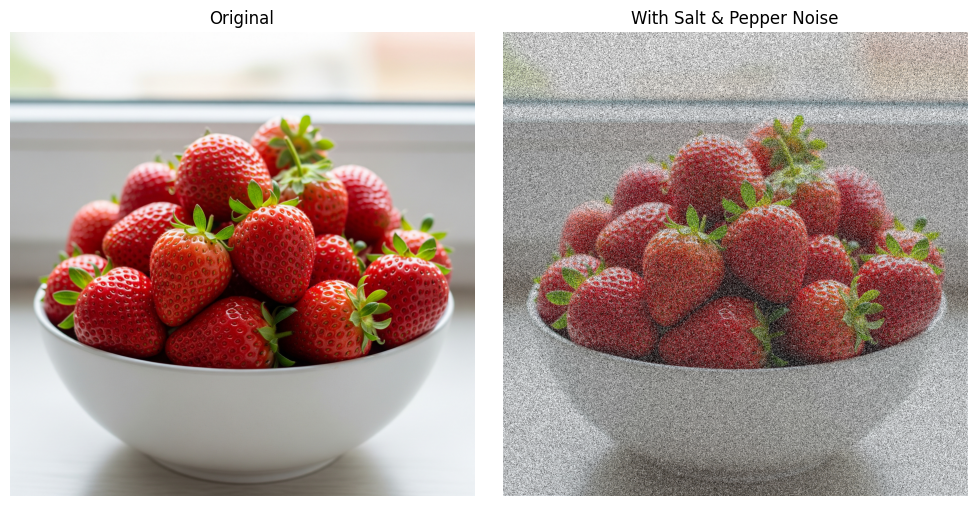

In [26]:
helper_utils.show_images(
    images=[original_image, sp_image],
    titles=("Original", "With Salt & Pepper Noise")
)

#### Normalize

[Normalize](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html?highlight=normalize) is a preprocessing step that standardizes the pixel values of an image. It subtracts the mean and divides by the standard deviation for each channel. This helps the model converge faster during training.

* It operates on an image tensor, subtracting the mean and dividing by the standard deviation for each channel.
    * `mean`: A sequence of mean values for each channel.
    * `std`: A sequence of standard deviation values for each channel.

**Note**: `transforms.ToTensor()` must always be applied before this transformation, as it operates on tensors, not PIL images.    

In [27]:
# Convert to tensor (scales to [0, 1])
tensor_image = transforms.ToTensor()(original_image)

# Define the normalization transform using ImageNet stats
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Apply the transformation
normalized_tensor = normalize_transform(tensor_image)

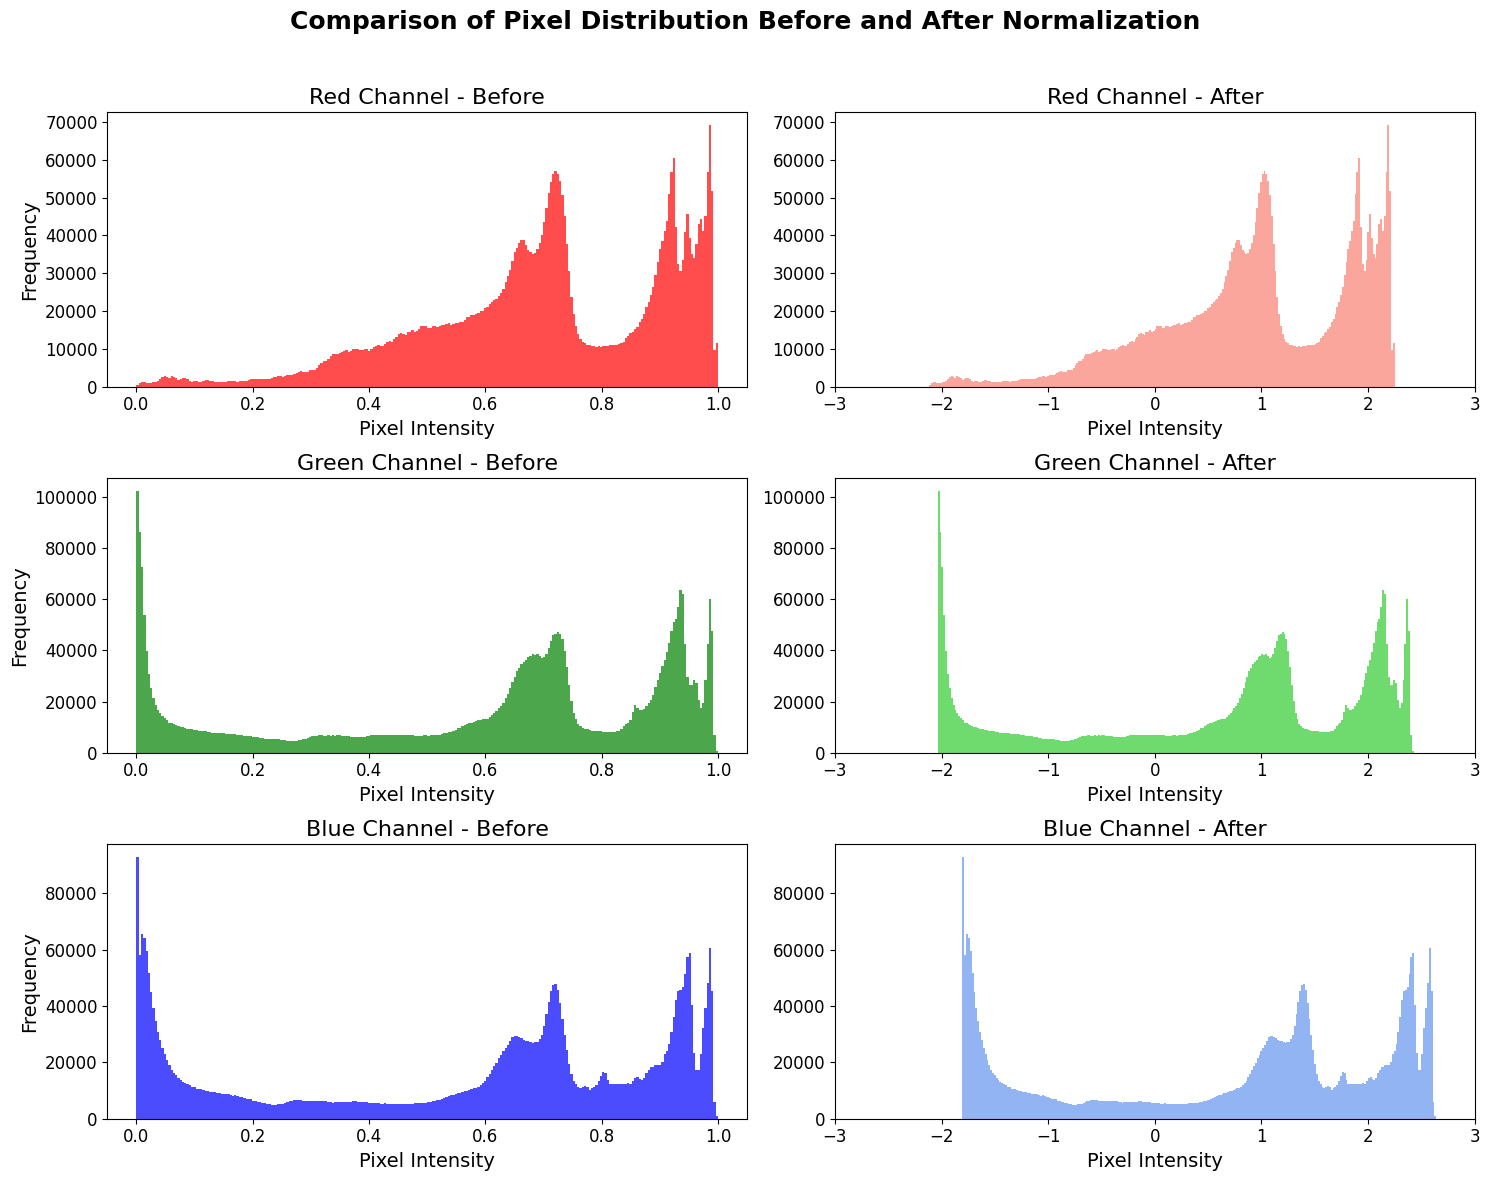

In [28]:
# Visualize the distribution before and after normalization
helper_utils.plot_histogram(tensor_image, normalized_tensor, "Comparison of Pixel Distribution Before and After Normalization")

##### Calculating Dataset Mean and Standard Deviation

When applying the normalization transformation, you used the well known mean and standard deviation from the ImageNet dataset:

> `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`

Using the well-known mean and standard deviation from a large dataset like ImageNet is a common and highly effective practice, especially when fine-tuning a pre-trained model. This approach aligns your new data with the statistical properties the model's weights were originally calibrated to, ensuring a stable and reliable starting point for training.

However, for optimal results, particularly when training a model from scratch, it is best to normalize data using its own specific statistics. Every dataset has a unique distribution of colors and brightness, and calculating its precise mean and standard deviation ensures the most accurate normalization possible, which can lead to improved model performance.

Think of these as strong recommendations, not strict rules. While using ImageNet stats is the safest approach for fine-tuning, you can use your own dataset's stats. Doing so may require more extensive training for the model to adapt to the new data distribution. For training from scratch, on the other hand, calculating your own stats is essential.

* The function, `calculate_mean_std`, iterates through the entire dataset to accumulate the sum and the sum-of-squares of the pixel values for each channel.
    * These accumulated values are then used to compute the final mean and standard deviation across all images in the dataset.

In [ ]:
def calculate_mean_std(dataset):
    """
    Calculates the mean and standard deviation of a PyTorch dataset.

    Args:
        dataset (torch.utils.data.Dataset): The dataset for which to
                                            calculate the stats. It should
                                            return image tensors.

    Returns:
        (torch.Tensor, torch.Tensor): A tuple containing the mean and
                                      standard deviation tensors, each of
                                      shape (C,).
    """
    # Create a DataLoader to iterate through the dataset in batches for efficiency.
    # shuffle=False because the order of images doesn't matter for this calculation.
    loader = data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

    # Initialize tensors to store the sum of pixel values for each (RGB) channel.
    channel_sum = torch.zeros(3)
    # Initialize tensors to store the sum of squared pixel values for each channel.
    channel_sum_sq = torch.zeros(3)
    # Initialize a counter for the total number of pixels.
    num_pixels = 0

    # Wrap the loader with tqdm to create a progress bar for monitoring.
    for images, _ in tqdm(loader, desc="Calculating Dataset Stats"):
        # Add the total number of pixels in this batch to the running total.
        num_pixels += images.size(0) * images.size(2) * images.size(3)
        
        # Sum the pixel values across the batch, height, and width dimensions,
        # leaving only the channel dimension. Add this to the running total.
        channel_sum += images.sum(dim=[0, 2, 3])
        
        # Square each pixel value, then sum them up similarly to the step above.
        channel_sum_sq += (images ** 2).sum(dim=[0, 2, 3])

    # Calculate the mean for each channel.
    mean = channel_sum / num_pixels
    # Calculate the standard deviation using the formula: sqrt(E[X^2] - E[X]^2)
    std = (channel_sum_sq / num_pixels - mean ** 2) ** 0.5

    # Return the calculated mean and standard deviation.
    return mean, std

<br>

Time to see the `calculate_mean_std function` in action. You'll now compute the specific statistics for the **OxfordIIITPet dataset**, and you'll use these calculated values in your final augmentation pipeline.

But before you can calculate the stats, you need to define a simple transformation pipeline.

**Why is `simple_transform` needed?**

You might wonder why you need to transform the images at all just to calculate their mean. Here's why this is important: 

* **`transforms.Resize((100, 100))`**: This performs two key functions: 
    * **Standardization**: It ensures every image has the exact same dimensions. This is important for a fair calculation, as it prevents larger or smaller images from skewing the overall result.
    * **Efficiency**: You deliberately use a *small* size (`(100, 100)`) as a practical optimization. Processing `100x100` images (10,000 pixels) is much faster than using a larger size like `224x224` (50,176 pixels), and the resulting stats are still an excellent approximation.
* **`transforms.ToTensor()`**: This is essential because your calculation function operates on numerical tensors, not PIL images. This transform converts the images into the required format and scales their pixel values to the `[0.0, 1.0]` range, which is standard for these types of computations.

In [ ]:
# Define a simple transformation
simple_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Load the OxfordIIITPet dataset, applying the simple transform to each image
my_dataset = datasets.OxfordIIITPet(root=ox3_pet_data_path,
                                    split='test',                 # Specify using the test set
                                    download=ox3_pet_download,    # Download if not already present
                                    transform=simple_transform    # Apply the defined transformations
                                   )

# Compute the mean and standard deviation for the dataset
dataset_mean, dataset_std = calculate_mean_std(my_dataset)

print(f"\nCalculation Complete.")
print(f"Dataset Mean: {dataset_mean}")
print(f"Dataset Std:  {dataset_std}")

<br>

Now that you have the specific mean and standard deviation for the **OxfordIIITPet dataset**, let's address a common question about their reusability.

**Are Stats from 100x100 Images Good Enough for a 224x224 Pipeline?**

**Yes, absolutely!** This is a pragmatic and widely used approach.

For most computer vision tasks, the statistics calculated from a smaller, resized version of an image are a very strong proxy for the original. The core subject (the pets) and color distribution remain the same. While resizing does introduce a tiny amount of statistical change (due to pixel interpolation), this difference is almost always negligible in practice.

The benefit is clear: you get a massive speed-up on a one-time calculation, and the resulting stats are far more representative of your dataset than generic values (like those from ImageNet). This is a classic case of a worthwhile trade-off between theoretical perfection and practical efficiency.

## Composing Transformations for Data Augmentation

The real power of transformations comes from chaining them together. `transforms.Compose` creates a single pipeline that applies a sequence of transformations to an image in order. 

* You will create two pipelines: 
    * `base_transform`: A simple pipeline with just the essential preprocessing steps (resizing and cropping). Normalization is intentionally skipped so the output images are visually correct and can serve as a clean baseline for comparison.
    * `full_augmentation_pipeline`: This includes your random, augmentative transforms and normalization using the stats you just calculated.
    
This will allow you to directly compare a "clean" batch of images with a fully augmented one.

In [ ]:
# A simple transform to get a clean, un-augmented version of the images
base_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    # Skip normalization to keep the image's pixel values in a display-friendly range.
])

# The full augmentation pipeline with all random transformations
full_augmentation_pipeline = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    SaltAndPepperNoise(amount=0.001),
    transforms.ToTensor(),
    # Using `mean` and `std` values as calculated on the 100x100 images
    transforms.Normalize(mean=dataset_mean,
                         std=dataset_std)
])

### A Dataset Without Augmentations

First, take a look at the data in its original form.

* Use a `DataLoader` with your `base_transform` pipeline to load a batch of images.
    * This applies only the necessary resizing and cropping, giving you a clean, consistent baseline to see what the images look like before any random augmentation is applied.

In [ ]:
# Load the dataset with ONLY the base transforms
original_dataset = datasets.OxfordIIITPet(root=ox3_pet_data_path, 
                                          split='test',
                                          download=ox3_pet_download,
                                          transform=base_transform
                                         )

# Create a DataLoader for the original images
original_loader = data.DataLoader(original_dataset, batch_size=9, shuffle=True)

In [ ]:
# Get one fixed batch of original images
original_images, _ = next(iter(original_loader))

# Create a grid from the batch of images, arranging them with 3 images per row.
grid = vutils.make_grid(original_images, nrow=3, padding=2) 

print("Original Un-augmented Batch:\n")
helper_utils.display_grid(grid)

### Applying the Augmentation Pipeline

Now, you'll see the effect of the `full_augmentation_pipeline`. You will take the same batch of original images from the previous step and apply the full pipeline to each one. You'll do this in a loop to see how the random augmentations change with each run.

This demonstrates the core concept of data augmentation. Because the pipeline includes random operations, applying it to an image produces a slightly different result each time. This is precisely what happens during model training when you pass an augmentation pipeline to a `DataLoader`. The transforms are applied on the fly, so with each epoch, your model is fed a unique version of the same original image. This process virtually increases the size and diversity of your training data without you having to collect more images, which helps your model generalize better and reduces overfitting.

**Note:** the image colors may appear different because each color channel has been normalized in this transformation. Feel free to comment out the `Normalize` and observe the difference in the images.

In [ ]:
# Use a loop to apply different random augmentations
for i in range(3):
    
    augmented_batch = []
    
    # Loop through each original image in the fixed batch
    for img_tensor in original_images:
        
        # Convert tensor back to PIL image to apply random transforms
        img_pil = transforms.ToPILImage()(img_tensor)

        # Apply the random augmentation pipeline
        augmented_tensor = full_augmentation_pipeline(img_pil)

        # Add the augmented tensor to the list for display
        augmented_batch.append(augmented_tensor)

    # Stack the list of augmented tensors into a single batch tensor
    final_batch = torch.stack(augmented_batch)

    # Create a grid from the batch of images, arranging them with 3 images per row
    grid = vutils.make_grid(final_batch, nrow=3, padding=2)
    
    print(f"\nAugmented Batch - Run #{i + 1}")
    helper_utils.display_grid(grid)

## Conclusion

Congratulations! You've successfully navigated the core components of image preprocessing and augmentation with TorchVision.

You saw firsthand how to build a flexible and powerful pipeline for preparing image data. You started with the fundamentals, such as converting images between the `Pillow (PIL)` format and `PyTorch Tensors`, and used essential utilities like `make_grid` for effective visualization.

From there, you explored the building blocks of data augmentation, applying individual transformations like `RandomResizedCrop` and `ColorJitter` and even defining a custom noise function from scratch. You also saw the importance of **normalization** and the best practice of calculating the specific mean and standard deviation for your dataset, a key step for stable and efficient training. Finally, you brought all these techniques together using `transforms.Compose` to create a sophisticated augmentation pipeline that transforms images on the fly.

These skills are foundational to virtually every computer vision task. A well-designed data pipeline, complete with thoughtful augmentations, not only makes your model more robust but also makes your entire workflow more efficient, reproducible, and reliable.